In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
import sacc
import sys
sys.path.insert(0, '/global/u1/z/zhzhuoqi/tjpcov/TJPCov')
sys.path.insert(0, '/global/u1/z/zhzhuoqi/firecrown/firecrown/')
sys.path.insert(0, '/global/homes/z/zhzhuoqi/.conda/envs/my-conda-env/lib/python3.8/site-packages/')
from tjpcov import wigner_transform, bin_cov, parse
d2r=np.pi/180

In [2]:
#this is the cosmology I use. 
cosmo = ccl.Cosmology(Omega_k=0.0, Omega_g=0.0, w0=-1.0, wa=0.0, T_CMB=2.7,
                      Neff=0, m_nu=0.0, transfer_function='bbks', mass_function='tinker',
                      Omega_b=0.045, Omega_c=0.21, h=0.71, sigma8=0.80, n_s=0.964)

In [3]:
# this sacc data has a number-count tracer and a weak-lensing tracer, both correspond
# to 0.8 < z < 1.0; and it has a cmb-lensing tracer
twopoint_data = sacc.Sacc.load_fits('test.sacc')

In [4]:
#use the same ell and ell_bins as namaster
nside = 1024
ell = np.linspace(2, int(nside*3), int(nside*3-1))
ell_bins = np.linspace(2, int(nside*3), int(nside*3./48))

In [5]:
#setup theta array and theta binning for wigner transform 
th_min=1/60 # in degrees
th_max=300./60
n_th_bins=20
th_bins=np.logspace(np.log10(2.5/60.),np.log10(250./60.),n_th_bins+1)

th=np.logspace(np.log10(th_min),np.log10(th_max),3000) #covariance is oversampled at th values and then binned.
th2=np.linspace(1,th_max*1.02,3000) #binned covariance can be sensitive to the th values. Make sue you check convergence for your application
th=np.unique(np.sort(np.append(th,th2)))
thb=0.5*(th_bins[1:]+th_bins[:-1])

In [6]:
# Wigner Transform setup... 
WT_kwargs={'l': ell,'theta': th*d2r,'s1_s2':[(0,2),(2,0),(0,0)]}
%time WT=wigner_transform(**WT_kwargs)

CPU times: user 835 ms, sys: 4.1 s, total: 4.94 s
Wall time: 1min 25s


In [7]:
# input basic info about the data
fsky=445./(4*np.pi*((180.**2)/(np.pi**2)))
Ngal = 0.479 #arc_min^2
Ngal=Ngal*3600/d2r**2
sigma_e=.0097

In [8]:
#get noises
nc_noise = 1./Ngal
wl_noise = sigma_e**2/Ngal
cmb_noise_smth = np.loadtxt('full_noise.txt')[1:nside*3]

In [9]:
# generate ccl tracers for number-count and cmb-lensing from sacc data
nc_tracer = twopoint_data.get_tracer('gc0')
nc_z = nc_tracer.z
nc_nz = nc_tracer.nz

bias = 1.80*np.ones(len(nc_z))
dNdz_nc = nc_nz
dNdz_nc/=(dNdz_nc*np.gradient(nc_z)).sum()
dNdz_nc*=Ngal

wl_tracer = twopoint_data.get_tracer('wl0')
wl_z = wl_tracer.z
wl_nz = wl_tracer.nz

dNdz_wl = wl_nz
dNdz_wl/=(dNdz_wl*np.gradient(wl_z)).sum()
dNdz_wl*=Ngal

nc_trcr = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(nc_z,dNdz_nc), bias=(nc_z,bias))
cmb_trcr = ccl.CMBLensingTracer(cosmo,1100.)
wl_trcr = ccl.WeakLensingTracer(cosmo, dndz=(wl_z,dNdz_wl))

## NK-NK covariance

In [10]:
# get ccl C_ell spectra
cl_nn = ccl.angular_cl(cosmo, nc_trcr, nc_trcr, ell)
cl_nk = ccl.angular_cl(cosmo, nc_trcr, cmb_trcr, ell)
cl_kn = ccl.angular_cl(cosmo, cmb_trcr, nc_trcr, ell)
cl_kk = ccl.angular_cl(cosmo, cmb_trcr, cmb_trcr, ell)

# add noise
cl_nn = cl_nn + nc_noise
cl_kk = cl_kk + cmb_noise_smth

In [11]:
# here is how tjpcov compute the covariance
norm = np.pi*4*fsky
coupling_mat = np.eye(len(ell))
cov1324 = np.outer(cl_nn, cl_kk)*coupling_mat
cov1423 = np.outer(cl_nk, cl_nk)*coupling_mat
cov = (cov1324+0*cov1423)/norm

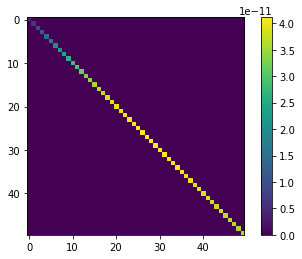

In [12]:
#plot the matrix feed to wigner transform
plt.imshow(cov[:50,:50])
plt.colorbar()

In [13]:
#wigner tranform
th,cov_=WT.projected_covariance2(l_cl=ell,s1_s2=(0,0), s1_s2_cross=(0,0),
                                                      cl_cov=cov)
#bin the covariance
thb, covar = bin_cov(r=th/d2r,r_bins=th_bins,cov=cov_) 

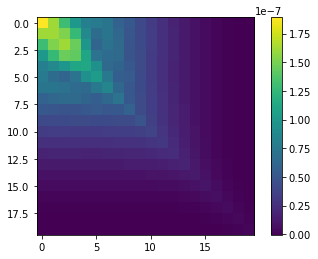

In [14]:
plt.imshow(covar)
plt.colorbar()

## GK-GK covariance

In [15]:
# get ccl C_ell spectra
cl_gg = ccl.angular_cl(cosmo, wl_trcr, wl_trcr, ell)
cl_gk = ccl.angular_cl(cosmo, wl_trcr, cmb_trcr, ell)
cl_kg = ccl.angular_cl(cosmo, cmb_trcr, wl_trcr, ell)
cl_kk = ccl.angular_cl(cosmo, cmb_trcr, cmb_trcr, ell)

# add noise
cl_gg = cl_gg + wl_noise
cl_kk = cl_kk + cmb_noise_smth

In [16]:
# here is how tjpcov compute the covariance
norm = np.pi*4*fsky
coupling_mat = np.eye(len(ell))
cov1324 = np.outer(cl_gg, cl_kk)*coupling_mat
cov1423 = np.outer(cl_gk, cl_gk)*coupling_mat
cov = (cov1324+0*cov1423)/norm

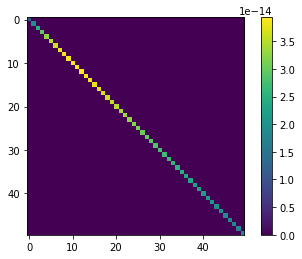

In [17]:
#plot the matrix feed to wigner transform
plt.imshow(cov[:50,:50])
plt.colorbar()

In [18]:
#wigner tranform
th,cov_=WT.projected_covariance2(l_cl=ell,s1_s2=(0,2), s1_s2_cross=(0,2),
                                                      cl_cov=cov)
#bin the covariance
thb, covar = bin_cov(r=th/d2r,r_bins=th_bins,cov=cov_) 

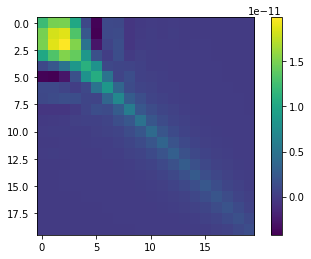

In [19]:
plt.imshow(covar)
plt.colorbar()